<a href="https://colab.research.google.com/github/beatricesoresina/QM2/blob/main/Game_Theory_BS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Adjacency Graph: Connectedness of European Countries

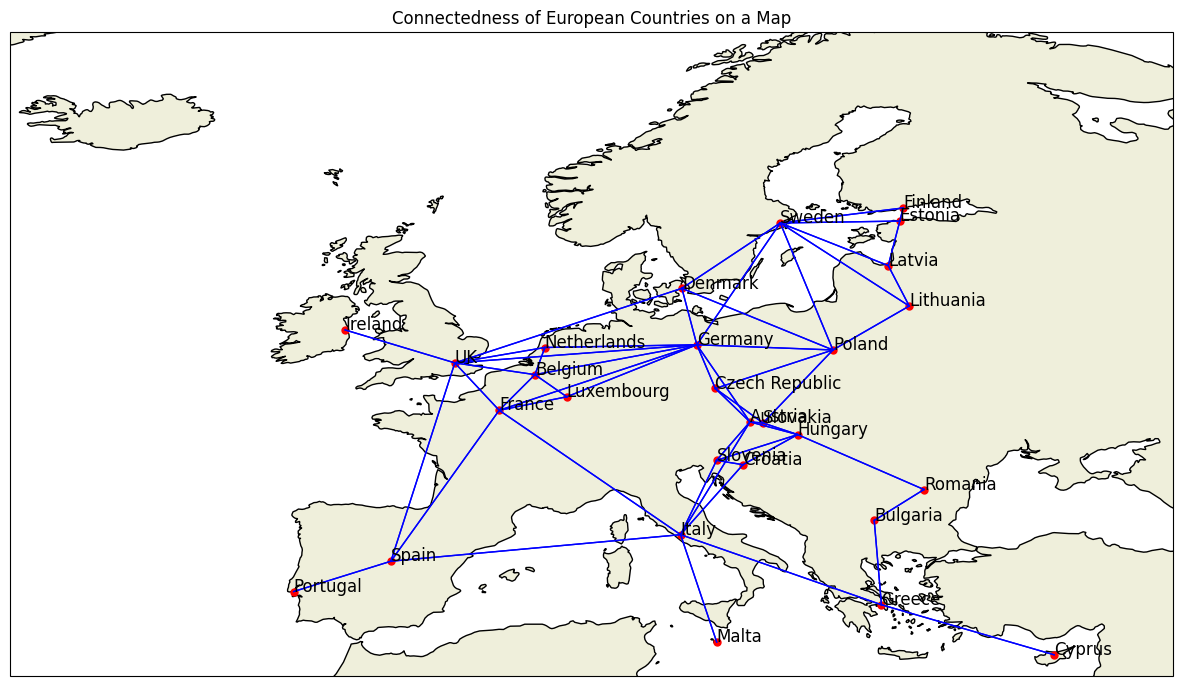

In [ ]:
!pip install cartopy

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Step 1: Load the CSV file
url = "https://raw.githubusercontent.com/beatricesoresina/BS-public-/main/New%20Adjacency%20Matrix%20EU%20.csv"
df = pd.read_csv(url, index_col=0)

# Verify dataframe dimensions and names
assert df.shape == (28, 28), "DataFrame shape is not 28x28 as expected."

# Step 2: Create a graph
G = nx.Graph()

# The dataframe index and columns represent the countries
countries = [
    "Sweden", "UK", "Ireland", "France", "Spain", "Portugal", "Germany", "Netherlands",
    "Belgium", "Luxembourg", "Italy", "Poland", "Czech Republic", "Austria",
    "Slovakia", "Hungary", "Slovenia", "Croatia", "Greece", "Romania",
    "Lithuania", "Latvia", "Estonia", "Finland", "Bulgaria", "Malta",
    "Cyprus", "Denmark"
]

# Geographical coordinates for the capital cities of the countries
coords = {
    'Sweden': (59.3293, 18.0686),
    'UK': (51.5074, -0.1278),
    'Ireland': (53.3498, -6.2603),
    'France': (48.8566, 2.3522),
    'Spain': (40.4168, -3.7038),
    'Portugal': (38.7223, -9.1393),
    'Germany': (52.5200, 13.4050),
    'Netherlands': (52.3676, 4.9041),
    'Belgium': (50.8503, 4.3517),
    'Luxembourg': (49.6116, 6.1319),
    'Italy': (41.9028, 12.4964),
    'Poland': (52.2297, 21.0122),
    'Czech Republic': (50.0755, 14.4378),
    'Austria': (48.2082, 16.3738),
    'Slovakia': (48.1486, 17.1077),
    'Hungary': (47.4979, 19.0402),
    'Slovenia': (46.0569, 14.5058),
    'Croatia': (45.8150, 15.9819),
    'Greece': (37.9838, 23.7275),
    'Romania': (44.4268, 26.1025),
    'Lithuania': (54.6872, 25.2797),
    'Latvia': (56.9496, 24.1052),
    'Estonia': (59.4369, 24.7536),
    'Finland': (60.1699, 24.9384),
    'Bulgaria': (42.6977, 23.3219),
    'Malta': (35.8989, 14.5146),
    'Cyprus': (35.1856, 33.3823),
    'Denmark': (55.6761, 12.5683)
}

# Confirm that the countries list matches the dataframe's rows/columns
assert all(country in df.index for country in countries), "Countries list does not match DataFrame index."
assert all(country in df.columns for country in countries), "Countries list does not match DataFrame columns."

# Add nodes based on countries list and their coordinates
for country, (lat, lon) in coords.items():
    G.add_node(country, pos=(lon, lat))

# Add edges based on adjacency matrix
for i, country1 in enumerate(countries):
    for j, country2 in enumerate(countries):
        if df.at[country1, country2] == 1:
            G.add_edge(country1, country2)

# Step 3: Draw the graph on a map of Europe using cartopy
fig, ax = plt.subplots(figsize=(15, 20), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-25, 40, 34, 70], crs=ccrs.PlateCarree())  # Set the extent to cover Europe

# Draw nodes
for country, (lat, lon) in coords.items():
    ax.plot(lon, lat, marker='o', color='red', markersize=5, transform=ccrs.Geodetic())
    ax.text(lon, lat, country, fontsize=12, transform=ccrs.Geodetic())

# Draw edges based on adjacency matrix
for i, country1 in enumerate(countries):
    for j, country2 in enumerate(countries):
        if df.at[country1, country2] == 1 and country1 != country2:
            lat1, lon1 = coords[country1]
            lat2, lon2 = coords[country2]
            ax.plot([lon1, lon2], [lat1, lat2], color='blue', linewidth=1, transform=ccrs.Geodetic())

plt.title("Connectedness of European Countries on a Map")
plt.show()


In [ ]:
#NASH EQUILIBRIUM: PDFO: INVESTMENT
#NO CONTROL BY EU (BETA=1) without any external control on pollution costs (𝛽=1)
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Preloaded data
co2_data_path = 'https://raw.githubusercontent.com/beatricesoresina/BS-public-/main/countrystatistic_id1171389_carbon-dioxide-emissions-in-the-european-union-2000-2022-by-country.csv'
eu_connections_url = 'https://raw.githubusercontent.com/beatricesoresina/BS-public-/main/New%20Adjacency%20Matrix%20EU%20.csv'

# Load and preprocess the data from the uploaded files
eu_connections = pd.read_csv(eu_connections_url)
owid_co2_data = pd.read_csv(co2_data_path)

# Replace 'Czechia' with 'Czech Republic' for compatibility
owid_co2_data['Country'] = owid_co2_data['Country'].replace('Czechia', 'Czech Republic')

# Helper function to get neighbors' influences
def get_neighbor_influences(country_index, investments, adjacency_matrix):
    return np.sum(adjacency_matrix[country_index] * investments)

# Cost function for each country
def cost_function(investments, country_index, xi, adjacency_matrix, beta=1, lambda_i=4):
    ui = investments[country_index]
    neighbor_influences = get_neighbor_influences(country_index, investments, adjacency_matrix)
    ci = np.exp(beta * ((1 - ui) * xi + neighbor_influences - ui * xi)) - 1 + lambda_i * ui
    return ci

# Total cost across all countries
def total_cost(investments, xis, adjacency_matrix, beta=1, lambda_i=4):
    return sum(cost_function(investments, i, xis[i], adjacency_matrix, beta, lambda_i) for i in range(len(investments)))

# Align and filter datasets
countries_adjacency = eu_connections['Unnamed: 0'].tolist()
countries_co2 = owid_co2_data['Country'].tolist()
common_countries = set(countries_adjacency).intersection(countries_co2)
adjacency_matrix_filtered = eu_connections.set_index('Unnamed: 0').loc[common_countries, common_countries].to_numpy()
owid_co2_data_filtered = owid_co2_data[owid_co2_data['Country'].isin(common_countries)]
owid_co2_data_filtered = owid_co2_data_filtered.set_index('Country').loc[common_countries].reset_index()
xis_filtered = owid_co2_data_filtered['2022'].to_numpy()
initial_investments_filtered = np.full(len(xis_filtered), 0.5)

# Define constraints for investments between 0 and 1
constraints = [{'type': 'ineq', 'fun': lambda x: x - 0},  # investments >= 0
               {'type': 'ineq', 'fun': lambda x: 1 - x}]  # investments <= 1

# Optimization using COBYLA
result_corrected = minimize(total_cost, initial_investments_filtered, args=(xis_filtered, adjacency_matrix_filtered),
                            method='COBYLA', constraints=constraints)

# Optimized investment levels
optimized_investments = result_corrected.x

# Display the optimized investment levels
print("Optimized Investment Levels:")
for i, country in enumerate(common_countries):
    print(f"{country}: {optimized_investments[i]:.4f}")



<ipython-input-196-23036c1cb57b>:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  adjacency_matrix_filtered = eu_connections.set_index('Unnamed: 0').loc[common_countries, common_countries].to_numpy()
<ipython-input-196-23036c1cb57b>:39: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  owid_co2_data_filtered = owid_co2_data_filtered.set_index('Country').loc[common_countries].reset_index()


Optimized Investment Levels:
France: 0.5143
Romania: 0.5341
Denmark: 0.5777
Slovakia: 0.5806
Estonia: 0.6146
Italy: 0.5129
Cyprus: 0.6292
Spain: 0.5121
Czech Republic: 0.5304
Latvia: 0.7162
Germany: 0.5089
Austria: 0.5588
Hungary: 0.5685
Ireland: 0.5410
Luxembourg: 0.6811
Netherlands: 0.5167
Poland: 0.5196
Slovenia: 0.6601
Portugal: 0.5428
Sweden: 0.5876
Lithuania: 0.6524
Belgium: 0.5269
Greece: 0.5412
Bulgaria: 0.5449
Croatia: 0.6208
Finland: 0.5583


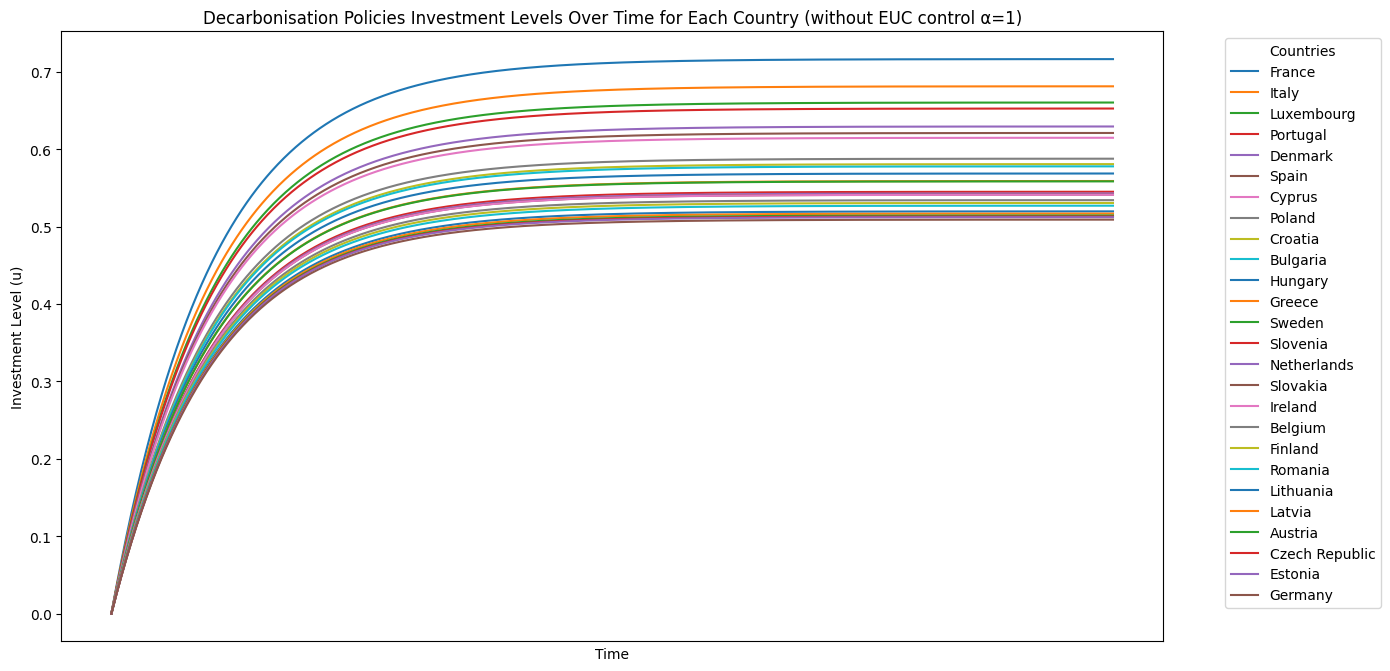

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'optimized_investments' and 'common_countries_sorted' are defined
# Sort the indices based on the investment levels from max to min
sorted_indices = np.argsort(optimized_investments)[::-1]
common_countries_sorted = sorted(list(common_countries))

sorted_countries = np.array(common_countries_sorted)[sorted_indices]
sorted_investments = optimized_investments[sorted_indices]

# Time parameters for the simulation
time = np.linspace(0, 10, 1000)  # Time from 0 to 10 with 1000 points

# Create the plot
plt.figure(figsize=(14, 7))

# Plot the investment level for each sorted country
for i, country in enumerate(sorted_countries):
    # Exponential growth towards the optimized investment level
    investment_level = sorted_investments[i] * (1 - np.exp(-time))
    plt.plot(time, investment_level, label=country)

# Formatting the plot
plt.xlabel('Time')
plt.ylabel('Investment Level (u)')
plt.title('Decarbonisation Policies Investment Levels Over Time for Each Country (without EUC control α=1)')
# Place the legend to the right of the plot, with countries ordered by max to min investment
plt.legend(sorted_countries, title='Countries', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks([])  # Hide the x-axis tick numbers

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
#NASH EQUILIBRIUM: POLLUTION: KR
# Necessary imports for the simulation
from scipy.integrate import solve_ivp

# Function that describes the pollution dynamics based on the Nash Equilibrium
def pollution_dynamics_nash(t, x, u_i, psi_ji_matrix):
    dxdt = np.zeros_like(x)
    for i in range(len(x)):
        sum_neighbors = np.sum(psi_ji_matrix[i] * (1 - u_i) * x)  # Calculate the influence from neighbors
        dxdt[i] = (1 - u_i[i]) * x[i] + sum_neighbors - u_i[i] * x[i]
    return dxdt

# Assuming optimized_investments contains the Nash Equilibrium investment levels
# and xis_filtered contains the initial pollution stock values for 2022
psi_ji_matrix = eu_connections_updated.values  # Adjacency matrix as influence matrix
u_i_nash = np.array(optimized_investments)  # Nash Equilibrium investment levels
x_0_nash = np.array(xis_filtered)  # Initial pollution stocks for 2022

# Time span for the simulation (replace T with your final time)
T = 10  # Example: Simulate up to 10 time units
t_span = (0, T)
t_eval = np.arange(0, T, 0.01)  # Time points where the solution is evaluated, with step size 0.01

# Solve the differential equation using the fourth-order Runge-Kutta method
sol_nash = solve_ivp(
    pollution_dynamics_nash,
    t_span,
    x_0_nash,
    method='RK45',
    t_eval=t_eval,
    args=(u_i_nash, psi_ji_matrix)
)

# Pollution stocks over time for Nash Equilibrium
pollution_stocks_nash = sol_nash.y


In [ ]:
#BASIC ITERATION GAME
# Assuming we have the adjacency matrix and initial investments ready
# Here, we adapt the code to perform the basic imitation game as described

def average_neighbor_investment(country_index, investments, adjacency_matrix):
    neighbors = np.where(adjacency_matrix[country_index] == 1)[0]
    if len(neighbors) == 0:
        return investments[country_index]
    else:
        return np.mean(investments[neighbors])

def update_investments_basic_imitation(investments, adjacency_matrix, tolerance=1e-3, max_iterations=1000):
    num_countries = len(investments)
    for iteration in range(max_iterations):
        new_investments = np.copy(investments)
        for i in range(num_countries):
            new_investments[i] = average_neighbor_investment(i, investments, adjacency_matrix)

        # Check for convergence
        if np.max(np.abs(new_investments - investments)) < tolerance:
            print(f"Convergence achieved after {iteration+1} iterations.")
            break
        investments = new_investments
    else:
        print("Maximum iterations reached without convergence.")

    return investments

# Example usage with dummy adjacency matrix and initial investments
# This is a placeholder; replace with actual adjacency matrix and investments
num_countries_example = len(common_countries)  # Assuming `common_countries` is the list of common countries
adjacency_matrix_example = np.random.randint(2, size=(num_countries_example, num_countries_example))
initial_investments_example = np.random.uniform(0, 1, num_countries_example)

# Update investments based on basic imitation
updated_investments = update_investments_basic_imitation(initial_investments_example, adjacency_matrix_example)
updated_investments
# Assuming `common_countries` contains the list of common countries used in the previous optimization
# and `updated_investments` contains the final investment levels from the Basic Imitation Game
# Let's print the investment levels for each country

# Ensure `common_countries` is sorted as it was during optimization
common_countries_sorted = sorted(list(common_countries))

# Print optimized investment levels per country after Basic Imitation Game
print("Final Investment Levels in Basic Imitation Game:")
for country, investment in zip(common_countries_sorted, updated_investments):
    print(f"{country}: {investment:.4f}")


Convergence achieved after 6 iterations.
Final Investment Levels in Basic Imitation Game:
Austria: 0.4533
Belgium: 0.4533
Bulgaria: 0.4533
Croatia: 0.4533
Cyprus: 0.4534
Czech Republic: 0.4533
Denmark: 0.4532
Estonia: 0.4534
Finland: 0.4531
France: 0.4532
Germany: 0.4534
Greece: 0.4533
Hungary: 0.4533
Ireland: 0.4532
Italy: 0.4533
Latvia: 0.4533
Lithuania: 0.4532
Luxembourg: 0.4533
Netherlands: 0.4534
Poland: 0.4533
Portugal: 0.4534
Romania: 0.4531
Slovakia: 0.4532
Slovenia: 0.4534
Spain: 0.4533
Sweden: 0.4535


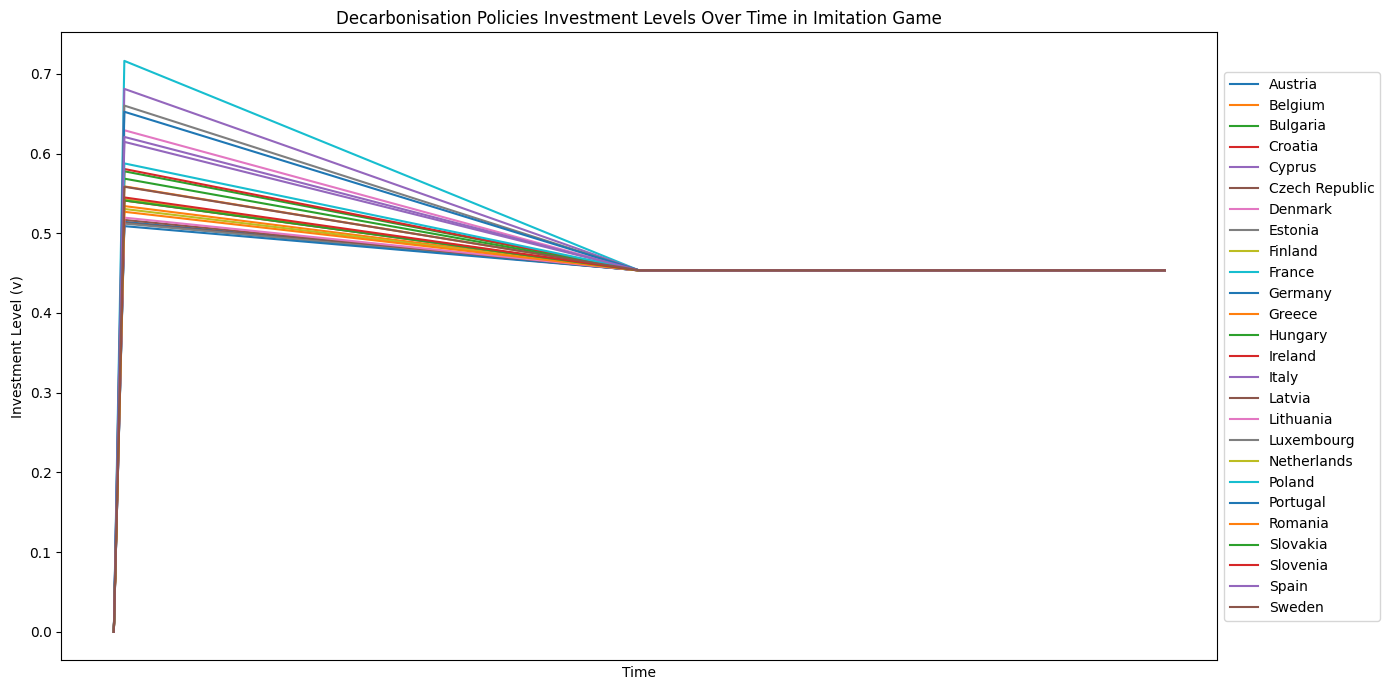

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate from time 0 to 100
time = np.linspace(0, 100, 1000)

# Initialize the plot
plt.figure(figsize=(14, 7))

# Function to model the investment level over time for each country
def model_investment(t, optimized_level, final_level):
    if t <= 1:
        return (optimized_level / 1) * t
    elif 1 < t < 50:
        # Gradual change: Use any function that smoothly transitions from optimized_level to final_level.
        # Here we use a simple linear interpolation for demonstration.
        return optimized_level + (final_level - optimized_level) * (t - 1) / (50 - 1)
    else:
        return final_level

# Loop through each country and plot the investment level over time
for i, country in enumerate(common_countries_sorted):
    # Get the optimized and final investment levels
    optimized_level = optimized_investments[i]
    final_level = updated_investments[i]

    # Calculate the investment level at each point in time
    investment_over_time = [model_investment(t, optimized_level, final_level) for t in time]

    # Plot the investment level for the country
    plt.plot(time, investment_over_time, label=country)

# Label the axes and add a title
plt.xlabel('Time')
plt.ylabel('Investment Level (v)')
plt.title('Decarbonisation Policies Investment Levels Over Time in Imitation Game')

# Adjust the legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Hide the x-axis numbers
plt.xticks([])

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Necessary imports for the simulation
from scipy.integrate import solve_ivp

# Assuming the adjacency matrix and initial investments are ready
# Define the pollution dynamics function for the Basic Imitation Game
def pollution_dynamics_imitation(t, x, u_i, psi_ji_matrix, adjacency_matrix):
    # Update the investments according to the Basic Imitation Game
    u_i = update_investments_basic_imitation(u_i, adjacency_matrix)

    # Calculate the change in pollution stocks using the updated investments
    dxdt = np.zeros_like(x)
    for i in range(len(x)):
        sum_neighbors = np.sum(psi_ji_matrix[i] * (1 - u_i) * x)
        dxdt[i] = (1 - u_i[i]) * x[i] + sum_neighbors - u_i[i] * x[i]
    return dxdt

# Assuming updated_investments contains the final investment levels from the Basic Imitation Game
# and xis_filtered contains the initial pollution stock values for 2022
psi_ji_matrix = eu_connections_updated.values  # Adjacency matrix as influence matrix
u_i_imitation = np.array(updated_investments)  # Final investment levels from Basic Imitation Game
x_0_imitation = np.array(xis_filtered)  # Initial pollution stocks for 2022

# Set up the simulation parameters
T = 10  # Simulation time, replace with the desired final time
t_span = (0, T)
t_eval = np.arange(0, T, 0.01)  # Time points for evaluating the solution, step size 0.01

# Solve the differential equation using the fourth-order Runge-Kutta method
sol_imitation = solve_ivp(
    pollution_dynamics_imitation,
    t_span,
    x_0_imitation,
    method='RK45',
    t_eval=t_eval,
    args=(u_i_imitation, psi_ji_matrix, adjacency_matrix_filtered)
)

# Pollution stocks over time for the Basic Imitation Game
pollution_stocks_imitation = sol_imitation.y

Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achieved after 1 iterations.
Convergence achi

In [ ]:
#STACKELBERG HIGH
#STRONG CONTROL BY LEADER (EU) BETA=16 WU any external control on pollution costs (𝛽=16)
#NASH EQUILIBRIUM: PDFO: INVESTMENT
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Preloaded data
co2_data_path = 'https://raw.githubusercontent.com/beatricesoresina/BS-public-/main/countrystatistic_id1171389_carbon-dioxide-emissions-in-the-european-union-2000-2022-by-country.csv'
eu_connections_url = 'https://raw.githubusercontent.com/beatricesoresina/BS-public-/main/New%20Adjacency%20Matrix%20EU%20.csv'

# Load and preprocess the data from the uploaded files
eu_connections = pd.read_csv(eu_connections_url)
owid_co2_data = pd.read_csv(co2_data_path)

# Replace 'Czechia' with 'Czech Republic' for compatibility
owid_co2_data['Country'] = owid_co2_data['Country'].replace('Czechia', 'Czech Republic')

# Helper function to get neighbors' influences
def get_neighbor_influences(country_index, investments, adjacency_matrix):
    return np.sum(adjacency_matrix[country_index] * investments)

# Cost function for each country
def cost_function(investments, country_index, xi, adjacency_matrix, beta=16, lambda_i=4):
    ui = investments[country_index]
    neighbor_influences = get_neighbor_influences(country_index, investments, adjacency_matrix)
    ci = np.exp(beta * ((1 - ui) * xi + neighbor_influences - ui * xi)) - 1 + lambda_i * ui
    return ci

# Total cost across all countries
def total_cost(investments, xis, adjacency_matrix, beta=16, lambda_i=4):
    return sum(cost_function(investments, i, xis[i], adjacency_matrix, beta, lambda_i) for i in range(len(investments)))

# Align and filter datasets
countries_adjacency = eu_connections['Unnamed: 0'].tolist()
countries_co2 = owid_co2_data['Country'].tolist()
common_countries = set(countries_adjacency).intersection(countries_co2)
adjacency_matrix_filtered = eu_connections.set_index('Unnamed: 0').loc[common_countries, common_countries].to_numpy()
owid_co2_data_filtered = owid_co2_data[owid_co2_data['Country'].isin(common_countries)]
owid_co2_data_filtered = owid_co2_data_filtered.set_index('Country').loc[common_countries].reset_index()
xis_filtered = owid_co2_data_filtered['2022'].to_numpy()
initial_investments_filtered = np.full(len(xis_filtered), 0.5)

# Define constraints for investments between 0 and 1
constraints = [{'type': 'ineq', 'fun': lambda x: x - 0},  # investments >= 0
               {'type': 'ineq', 'fun': lambda x: 1 - x}]  # investments <= 1

# Optimization using COBYLA
result_corrected = minimize(total_cost, initial_investments_filtered, args=(xis_filtered, adjacency_matrix_filtered),
                            method='COBYLA', constraints=constraints)

# Optimized investment levels
optimized_investments = result_corrected.x

# Display the optimized investment levels
print("Optimized Investment Levels:")
for i, country in enumerate(common_countries):
    print(f"{country}: {optimized_investments[i]:.4f}")


Optimized Investment Levels:
France: 0.5000
Romania: 0.5000
Denmark: 0.5000
Slovakia: 0.5000
Estonia: 0.5000
Italy: 0.5000
Cyprus: 0.5000
Spain: 0.5000
Czech Republic: 0.5000
Latvia: 0.5000
Germany: 0.5000
Austria: 0.5000
Hungary: 0.5000
Ireland: 0.5000
Luxembourg: 0.5000
Netherlands: 0.5000
Poland: 0.5000
Slovenia: 0.5000
Portugal: 0.5000
Sweden: 0.5000
Lithuania: 0.5000
Belgium: 0.5000
Greece: 0.5000
Bulgaria: 0.5000
Croatia: 0.5000
Finland: 0.5000


<ipython-input-202-7de11463639e>:38: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  adjacency_matrix_filtered = eu_connections.set_index('Unnamed: 0').loc[common_countries, common_countries].to_numpy()
<ipython-input-202-7de11463639e>:40: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  owid_co2_data_filtered = owid_co2_data_filtered.set_index('Country').loc[common_countries].reset_index()
<ipython-input-202-7de11463639e>:27: RuntimeWarning: overflow encountered in exp
  ci = np.exp(beta * ((1 - ui) * xi + neighbor_influences - ui * xi)) - 1 + lambda_i * ui


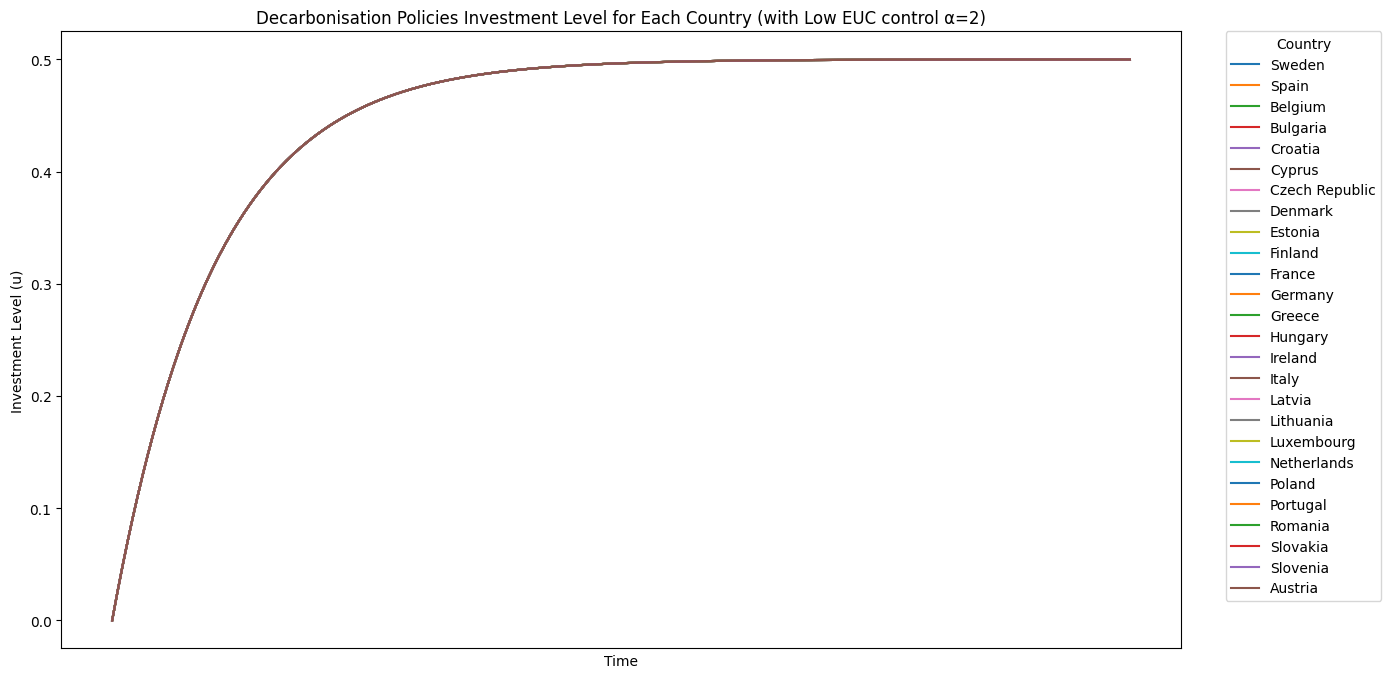

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'optimized_investments' and 'common_countries_sorted' are already defined
# Sort the countries by their optimized investments in descending order
sorted_indices = np.argsort(optimized_investments)[::-1]
sorted_countries = [common_countries_sorted[i] for i in sorted_indices]
sorted_investments = optimized_investments[sorted_indices]

# Define the time period for the simulation
time = np.linspace(0, 10, 1000)  # 1000 points from 0 to 10 for a smooth line

# Initialize the plot
plt.figure(figsize=(14, 7))

# Plot the exponential increase to the optimized investment level for each country
for country, investment in zip(sorted_countries, sorted_investments):
    investment_level = investment * (1 - np.exp(-time))
    plt.plot(time, investment_level, label=country)

# Labeling and formatting
plt.xlabel('Time')
plt.ylabel('Investment Level (u)')
plt.title('Decarbonisation Policies Investment Level for Each Country (with Low EUC control α=2)')
plt.xticks([])  # Remove x-axis numbers

# Place the legend on the right side of the plot with countries sorted by their optimized investment
plt.legend(title='Country', bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0)

# Show the plot with a tight layout
plt.tight_layout()
plt.show()


In [ ]:
#STACKELBERG LOW
#STRONG CONTROL BY LEADER (EU) BETA= 2 WU any external control on pollution costs (𝛽=2)
#NASH EQUILIBRIUM: PDFO: INVESTMENT
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Preloaded data
co2_data_path = 'https://raw.githubusercontent.com/beatricesoresina/BS-public-/main/countrystatistic_id1171389_carbon-dioxide-emissions-in-the-european-union-2000-2022-by-country.csv'
eu_connections_url = 'https://raw.githubusercontent.com/beatricesoresina/BS-public-/main/New%20Adjacency%20Matrix%20EU%20.csv'

# Load and preprocess the data from the uploaded files
eu_connections = pd.read_csv(eu_connections_url)
owid_co2_data = pd.read_csv(co2_data_path)

# Replace 'Czechia' with 'Czech Republic' for compatibility
owid_co2_data['Country'] = owid_co2_data['Country'].replace('Czechia', 'Czech Republic')

# Helper function to get neighbors' influences
def get_neighbor_influences(country_index, investments, adjacency_matrix):
    return np.sum(adjacency_matrix[country_index] * investments)

# Cost function for each country
def cost_function(investments, country_index, xi, adjacency_matrix, beta=2, lambda_i=4):
    ui = investments[country_index]
    neighbor_influences = get_neighbor_influences(country_index, investments, adjacency_matrix)
    ci = np.exp(beta * ((1 - ui) * xi + neighbor_influences - ui * xi)) - 1 + lambda_i * ui
    return ci

# Total cost across all countries
def total_cost(investments, xis, adjacency_matrix, beta=2, lambda_i=4):
    return sum(cost_function(investments, i, xis[i], adjacency_matrix, beta, lambda_i) for i in range(len(investments)))

# Align and filter datasets
countries_adjacency = eu_connections['Unnamed: 0'].tolist()
countries_co2 = owid_co2_data['Country'].tolist()
common_countries = set(countries_adjacency).intersection(countries_co2)
adjacency_matrix_filtered = eu_connections.set_index('Unnamed: 0').loc[common_countries, common_countries].to_numpy()
owid_co2_data_filtered = owid_co2_data[owid_co2_data['Country'].isin(common_countries)]
owid_co2_data_filtered = owid_co2_data_filtered.set_index('Country').loc[common_countries].reset_index()
xis_filtered = owid_co2_data_filtered['2022'].to_numpy()
initial_investments_filtered = np.full(len(xis_filtered), 0.5)

# Define constraints for investments between 0 and 1
constraints = [{'type': 'ineq', 'fun': lambda x: x - 0},  # investments >= 0
               {'type': 'ineq', 'fun': lambda x: 1 - x}]  # investments <= 1

# Optimization using COBYLA
result_corrected = minimize(total_cost, initial_investments_filtered, args=(xis_filtered, adjacency_matrix_filtered),
                            method='COBYLA', constraints=constraints)

# Optimized investment levels
optimized_investments = result_corrected.x

# Display the optimized investment levels
print("Optimized Investment Levels:")
for i, country in enumerate(common_countries):
    print(f"{country}: {optimized_investments[i]:.4f}")

<ipython-input-204-0c81d3f33236>:38: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  adjacency_matrix_filtered = eu_connections.set_index('Unnamed: 0').loc[common_countries, common_countries].to_numpy()
<ipython-input-204-0c81d3f33236>:40: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  owid_co2_data_filtered = owid_co2_data_filtered.set_index('Country').loc[common_countries].reset_index()


Optimized Investment Levels:
France: 0.5120
Romania: 0.5219
Denmark: 0.5578
Slovakia: 0.5660
Estonia: 0.5950
Italy: 0.5099
Cyprus: 0.6058
Spain: 0.5092
Czech Republic: 0.5238
Latvia: 0.6929
Germany: 0.5062
Austria: 0.5472
Hungary: 0.5546
Ireland: 0.5323
Luxembourg: 0.6623
Netherlands: 0.5109
Poland: 0.5105
Slovenia: 0.6397
Portugal: 0.6031
Sweden: 0.5704
Lithuania: 0.6221
Belgium: 0.5671
Greece: 0.5309
Bulgaria: 0.5318
Croatia: 0.5967
Finland: 0.5439


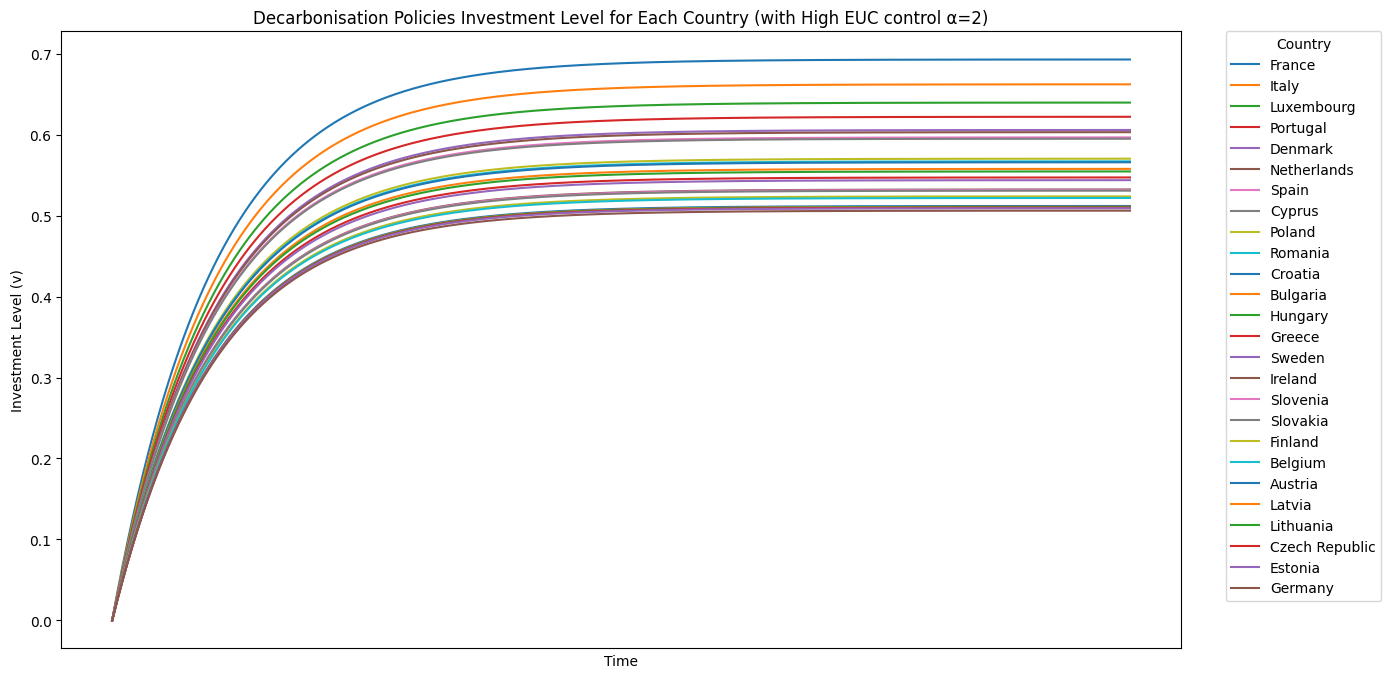

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'optimized_investments' and 'common_countries_sorted' are already defined
# Sort the countries by their optimized investments in descending order
sorted_indices = np.argsort(optimized_investments)[::-1]
sorted_countries = [common_countries_sorted[i] for i in sorted_indices]
sorted_investments = optimized_investments[sorted_indices]

# Define the time period for the simulation
time = np.linspace(0, 10, 1000)  # 1000 points from 0 to 10 for a smooth line

# Initialize the plot
plt.figure(figsize=(14, 7))

# Plot the exponential increase to the optimized investment level for each country
for country, investment in zip(sorted_countries, sorted_investments):
    investment_level = investment * (1 - np.exp(-time))
    plt.plot(time, investment_level, label=country)

# Labeling and formatting
plt.xlabel('Time')
plt.ylabel('Investment Level (v)')
plt.title('Decarbonisation Policies Investment Level for Each Country (with High EUC control α=2)')
plt.xticks([])  # Remove x-axis numbers

# Place the legend on the right side of the plot with countries sorted by their optimized investment
plt.legend(title='Country', bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0)

# Show the plot with a tight layout
plt.tight_layout()
plt.show()
